# Task 2 Multiclass classification Baseline

In this class, we will develop a baseline for Task 2 using the chess dataset. We will model the task as an multiclass classification task.

In [ ]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2, json
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import models
from torchvision.transforms import v2 as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch
import time

random.seed(42)

## Load dataset

**Tip**: since the images are very big, resize the dataset before loading it to save time and memory during training (use cubic interpolation to preserve image quality when downsizing the images)!

In [2]:
# Normalize images
'''data_aug = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])'''

data_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_in = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
def chesspos2number(chesspos):
    col = ord(chesspos[0])-ord('a')
    row = int(chesspos[1])-1
    return row, col

class ChessDataset(Dataset):
    def __init__(self, root_dir, partition, transform=None):
        self.anns = json.load(open(os.path.join(root_dir, 'annotations.json')))
        self.categories = [c['name'] for c in self.anns['categories']]
        self.root = root_dir
        self.ids = []
        self.file_names = []
        for x in self.anns['images']:
            self.file_names.append(x['path'])
            self.ids.append(x['id'])
        self.file_names = np.asarray(self.file_names)
        self.ids = np.asarray(self.ids)
        self.boards = torch.zeros((len(self.file_names), 8, 8))
        for piece in self.anns['annotations']['pieces']:
            idx = np.where(self.ids == piece['image_id'])[0][0]
            row, col = chesspos2number(piece['chessboard_position'])
            self.boards[idx][row][col] = 1

        if partition == 'train':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['train']['image_ids']).astype(int)
        elif partition == 'valid':
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['val']['image_ids']).astype(int)
        else:
            self.split_ids = np.asarray(self.anns['splits']['chessred2k']['test']['image_ids']).astype(int)

        intersect = np.isin(self.ids, self.split_ids)
        self.split_ids = np.where(intersect)[0]
        self.file_names = self.file_names[self.split_ids]
        self.boards = self.boards[self.split_ids]

        '''self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1)
        self.num_pieces = F.one_hot(self.num_pieces.long()-1, 32)'''

        self.num_pieces = torch.sum(self.boards.view(len(self.boards), 64), axis=-1).float()

        self.ids = self.ids[self.split_ids]

        self.transform = transform
        print(f"Number of {partition} images: {len(self.file_names)}")

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, i):
        image = cv2.imread(os.path.join(self.root, self.file_names[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        num_pieces = self.num_pieces[i]

        '''return image, num_pieces.float()'''
        return image, num_pieces.unsqueeze(0)

train_dataset = ChessDataset('', 'train', data_aug)
valid_dataset = ChessDataset('', 'valid', data_in)
test_dataset = ChessDataset('', 'test', data_in)

Number of train images: 1442
Number of valid images: 330
Number of test images: 306


In [4]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 32
num_workers = 0

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


torch.Size([32, 224, 224, 3])
torch.Size([32, 1])
tensor(1)


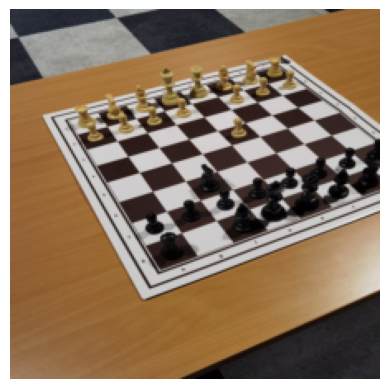

In [5]:
for batch in train_dataloader:
    # Get images of the batch and print their dimensions
    imgs = batch[0]
    imgs = imgs.permute(0, 2, 3, 1)*torch.tensor([[[0.229, 0.224, 0.225]]]) + torch.tensor([[[0.485, 0.456, 0.406]]])
    print(imgs.shape)

    # Get labels of each image in the batch and print them
    labels = batch[1]
    print(labels.shape)
    print(torch.argmax(labels[0])+1)

    # Show first image of the batch
    plt.imshow(imgs[0])
    plt.axis('off')
    plt.show()

    break

## Defining the model

We will use a pre-trained ResNet50 network.

In [6]:
'''# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Load pretrained ResNet-50
model = models.resnet50(pretrained=True)

# Replace final classification layer (default is 1000 for ImageNet)
# You want 32 outputs — one for each possible number of pieces on the board (1 to 32)
model.fc = nn.Linear(model.fc.in_features, 32)

# Move model to device
model.to(device)'''


'# Get device\ndevice = "cuda" if torch.cuda.is_available() else "cpu"\nprint(f"Using {device} device")\n\n# Load pretrained ResNet-50\nmodel = models.resnet50(pretrained=True)\n\n# Replace final classification layer (default is 1000 for ImageNet)\n# You want 32 outputs — one for each possible number of pieces on the board (1 to 32)\nmodel.fc = nn.Linear(model.fc.in_features, 32)\n\n# Move model to device\nmodel.to(device)'

## Train the model

Define function to perform one iteration

In [7]:
'''def train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    images = images.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(is_train):
        outputs = model(images)
        loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return loss.item(), outputs'''

'def train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True):\n    if is_train:\n        model.train()\n    else:\n        model.eval()\n\n    images = images.to(device)\n    labels = labels.to(device)\n\n    with torch.set_grad_enabled(is_train):\n        outputs = model(images)\n        loss = criterion(outputs, labels)\n\n        if is_train:\n            optimizer.zero_grad()\n            loss.backward()\n            optimizer.step()\n\n    return loss.item(), outputs'

Define function to train a model

In [8]:
'''def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    best_val_acc = 0.0
    best_model_path = 'best_model.pth'

    train_history = {'loss': [], 'accuracy': []}
    val_history = {'loss': [], 'accuracy': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Treino
        running_loss = 0.0
        correct_preds = 0
        total_samples = 0
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_bar:
            loss, outputs = train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True)
            running_loss += loss * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            true_labels = torch.argmax(labels, dim=1).to(device)
            correct_preds += (preds == true_labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            train_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)

        train_history['loss'].append(avg_loss)
        train_history['accuracy'].append(avg_acc)
        print(f"✔️ Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_acc:.4f}")

        # Validação
        if val_loader:
            running_loss = 0.0
            correct_preds = 0
            total_samples = 0
            val_bar = tqdm(val_loader, desc="Validation", leave=False)

            for images, labels in val_bar:
                loss, outputs = train_one_iteration(model, images, labels, optimizer=None, criterion=criterion, device=device, is_train=False)
                running_loss += loss * images.size(0)

                preds = torch.argmax(outputs, dim=1)
                true_labels = torch.argmax(labels, dim=1).to(device)
                correct_preds += (preds == true_labels).sum().item()
                total_samples += labels.size(0)

                avg_loss = running_loss / total_samples
                avg_acc = correct_preds / total_samples
                val_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)

            val_loss = running_loss / total_samples
            val_acc = correct_preds / total_samples
            val_history['loss'].append(val_loss)
            val_history['accuracy'].append(val_acc)
            print(f"🔍 Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_model_path)
                print(f"💾 Best model saved with accuracy: {best_val_acc:.4f}")

    return train_history, val_history'''

'def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):\n    best_val_acc = 0.0\n    best_model_path = \'best_model.pth\'\n\n    train_history = {\'loss\': [], \'accuracy\': []}\n    val_history = {\'loss\': [], \'accuracy\': []}\n\n    for epoch in range(num_epochs):\n        print(f"\nEpoch {epoch+1}/{num_epochs}")\n\n        # Treino\n        running_loss = 0.0\n        correct_preds = 0\n        total_samples = 0\n        train_bar = tqdm(train_loader, desc="Training", leave=False)\n\n        for images, labels in train_bar:\n            loss, outputs = train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True)\n            running_loss += loss * images.size(0)\n\n            preds = torch.argmax(outputs, dim=1)\n            true_labels = torch.argmax(labels, dim=1).to(device)\n            correct_preds += (preds == true_labels).sum().item()\n            total_samples += labels.size(0)\n\n            avg_loss = ru

Define loss, optimizer and train the model

In [9]:
'''# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs
num_epochs = 2

# Train the model
train_history, val_history = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)
'''

'# Define loss function\nloss_fn = nn.CrossEntropyLoss()\n\n# Define optimizer\noptimizer = optim.Adam(model.parameters(), lr=1e-4)\n\n# Number of epochs\nnum_epochs = 2\n\n# Train the model\ntrain_history, val_history = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)\n'

## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [10]:
'''def plot_training_history(train_history, val_history):
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(train_history['loss'], label='Train Loss')
    plt.plot(val_history['loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_history['accuracy'], label='Train Accuracy')
    plt.plot(val_history['accuracy'], label='Val Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()'''

"def plot_training_history(train_history, val_history):\n    plt.figure(figsize=(12,5))\n\n    plt.subplot(1, 2, 1)\n    plt.plot(train_history['loss'], label='Train Loss')\n    plt.plot(val_history['loss'], label='Val Loss')\n    plt.title('Loss over epochs')\n    plt.xlabel('Epoch')\n    plt.ylabel('Loss')\n    plt.legend()\n\n    plt.subplot(1, 2, 2)\n    plt.plot(train_history['accuracy'], label='Train Accuracy')\n    plt.plot(val_history['accuracy'], label='Val Accuracy')\n    plt.title('Accuracy over epochs')\n    plt.xlabel('Epoch')\n    plt.ylabel('Accuracy')\n    plt.legend()\n\n    plt.tight_layout()\n    plt.show()"

In [11]:
'''plot_training_history(train_history, val_history)'''

'plot_training_history(train_history, val_history)'

## Test the model

Evaluate the model in the test set

In [12]:
'''def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = torch.argmax(labels, dim=1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            test_bar.set_postfix(loss=avg_loss, acc=avg_acc)

    test_loss = running_loss / total_samples
    test_acc = correct_preds / total_samples

    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
'''

'def test_model(model, test_loader, criterion, device):\n    model.eval()\n    running_loss = 0.0\n    correct_preds = 0\n    total_samples = 0\n\n    test_bar = tqdm(test_loader, desc="Testing")\n\n    with torch.no_grad():\n        for images, labels in test_bar:\n            images = images.to(device)\n            labels = torch.argmax(labels, dim=1).to(device)\n\n            outputs = model(images)\n            loss = criterion(outputs, labels)\n\n            running_loss += loss.item() * images.size(0)\n            _, preds = torch.max(outputs, 1)\n            correct_preds += (preds == labels).sum().item()\n            total_samples += labels.size(0)\n\n            avg_loss = running_loss / total_samples\n            avg_acc = correct_preds / total_samples\n            test_bar.set_postfix(loss=avg_loss, acc=avg_acc)\n\n    test_loss = running_loss / total_samples\n    test_acc = correct_preds / total_samples\n\n    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:

In [13]:
'''def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded model from {model_path}")'''

'def load_model(model, model_path, device):\n    model.load_state_dict(torch.load(model_path, map_location=device))\n    model.to(device)\n    model.eval()\n    print(f"Loaded model from {model_path}")'

In [14]:
'''def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = torch.argmax(labels, dim=1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            test_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)

    test_loss = running_loss / total_samples
    test_acc = correct_preds / total_samples

    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
    return test_loss, test_acc

# Exemplo de uso:

best_model_path = 'best_model.pth'  # caminho para o melhor modelo guardado

# Carrega o modelo antes do teste
load_model(model, best_model_path, device)

# Avalia no conjunto de teste
test_loss, test_acc = test_model(model, test_dataloader, loss_fn, device)'''

'def test_model(model, test_loader, criterion, device):\n    model.eval()\n    running_loss = 0.0\n    correct_preds = 0\n    total_samples = 0\n\n    test_bar = tqdm(test_loader, desc="Testing")\n\n    with torch.no_grad():\n        for images, labels in test_bar:\n            images = images.to(device)\n            labels = torch.argmax(labels, dim=1).to(device)\n\n            outputs = model(images)\n            loss = criterion(outputs, labels)\n\n            running_loss += loss.item() * images.size(0)\n            _, preds = torch.max(outputs, 1)\n            correct_preds += (preds == labels).sum().item()\n            total_samples += labels.size(0)\n\n            avg_loss = running_loss / total_samples\n            avg_acc = correct_preds / total_samples\n            test_bar.set_postfix(loss=avg_loss, accuracy=avg_acc)\n\n    test_loss = running_loss / total_samples\n    test_acc = correct_preds / total_samples\n\n    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test

## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!

## For Group Project - Task 2: Adapt multiclass classification network to regression!

Now that you have a multiclass baseline, adapt the network for the regression problem, considering the following aspects:
* How many neurons should the last layer of a regression network have?
* What should be the final activation function for a regression network?
* What loss functions can be used to train a regression network?

# **Now trying new approach with a different model**



## Defining the model

We will use a pre-trained ResNet50 network.

In [ ]:
from torchvision.models import efficientnet_b0, efficientnet_b4

# First we started with EfficientNet-B0 and optimized it and then we moved to EfficientNet-B4

# Get device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# # Load pretrained EfficientNet-B0
# model = efficientnet_b0(pretrained=True)

model = efficientnet_b4(pretrained=True)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

# Move model to device
model.to(device)


Using cuda device


c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\diogo\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Train the model

Define function to perform one iteration

In [16]:
def train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    images = images.to(device)
    labels = labels.to(device).float()
    if labels.dim() == 3:
        labels = labels.squeeze(-1)
    if labels.dim() == 1:
        labels = labels.unsqueeze(1)

    with torch.set_grad_enabled(is_train):
        outputs = model(images)
        loss = criterion(outputs, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return loss.item(), outputs

Define function to train a model

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10):
    best_val_loss = float('inf')
    best_model_path = 'best_model.pth'

    train_history = {'loss': [], 'mae': []}
    val_history = {'loss': [], 'mae': []}

    # Armazenar o tempo total de treino
    total_train_time = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        epoch_start_time = time.time()  # Iniciar contagem do tempo da época

        running_loss = 0.0
        running_mae = 0.0
        total_samples = 0
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_bar:
            loss, outputs = train_one_iteration(model, images, labels, optimizer, criterion, device, is_train=True)

            mae = F.l1_loss(outputs, labels.to(device).float().unsqueeze(1))

            running_loss += loss * images.size(0)
            running_mae += mae.item() * images.size(0)
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_mae = running_mae / total_samples
            train_bar.set_postfix(loss=avg_loss, MAE=avg_mae)

        train_history['loss'].append(avg_loss)
        train_history['mae'].append(avg_mae)
        print(f"✔️ Train Loss: {avg_loss:.4f} | Train MAE: {avg_mae:.4f}")

        # Fim da época: calcular o tempo total da época
        epoch_end_time = time.time()
        epoch_time = epoch_end_time - epoch_start_time
        total_train_time += epoch_time
        print(f"Epoch {epoch+1} took {epoch_time:.2f} seconds.")

        if val_loader:
            running_val_loss = 0.0
            running_val_mae = 0.0
            total_val_samples = 0
            val_bar = tqdm(val_loader, desc="Validation", leave=False)

            for images, labels in val_bar:
                loss, outputs = train_one_iteration(model, images, labels, optimizer=None, criterion=criterion, device=device, is_train=False)

                mae = F.l1_loss(outputs, labels.to(device).float().unsqueeze(1))

                running_val_loss += loss * images.size(0)
                running_val_mae += mae.item() * images.size(0)
                total_val_samples += labels.size(0)

                avg_val_loss = running_val_loss / total_val_samples
                avg_val_mae = running_val_mae / total_val_samples
                val_bar.set_postfix(loss=avg_val_loss, MAE=avg_val_mae)

            val_history['loss'].append(avg_val_loss)
            val_history['mae'].append(avg_val_mae)
            print(f"🔍 Validation Loss: {avg_val_loss:.4f} | Validation MAE: {avg_val_mae:.4f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"💾 Best model saved with val loss: {best_val_loss:.4f}")

    # Exibir o tempo total de treinamento
    print(f"\nTotal training time: {total_train_time:.2f} seconds.")

    return train_history, val_history, total_train_time

Define loss, optimizer and train the model

In [18]:
'''model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

for param in model.parameters():
    param.requires_grad = False
for param in model.classifier[1].parameters():
    param.requires_grad = True

model.to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=1e-3)

num_epochs = 10
train_history, val_history = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)

for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50

train_history_finetune, val_history_finetune = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)'''

'model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)\n\nfor param in model.parameters():\n    param.requires_grad = False\nfor param in model.classifier[1].parameters():\n    param.requires_grad = True\n\nmodel.to(device)\n\nloss_fn = nn.MSELoss()\noptimizer = optim.Adam(model.classifier[1].parameters(), lr=1e-3)\n\nnum_epochs = 10\ntrain_history, val_history = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)\n\nfor param in model.parameters():\n    param.requires_grad = True\n\noptimizer = optim.Adam(model.parameters(), lr=1e-4)\n\nnum_epochs = 50\n\ntrain_history_finetune, val_history_finetune = train_model(model, train_dataloader, valid_dataloader, optimizer, loss_fn, device, num_epochs)'

In [19]:
def plot_training_history(train_history, val_history):
    plt.figure(figsize=(12,5))

    plt.subplot(1, 2, 1)
    plt.plot(train_history['loss'], label='Train Loss')
    plt.plot(val_history['loss'], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_history['mae'], label='Train MAE')
    plt.plot(val_history['mae'], label='Val MAE')
    plt.title('MAE over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [20]:
'''plot_training_history(train_history, val_history)'''

'plot_training_history(train_history, val_history)'

In [21]:
'''plot_training_history(train_history_finetune, val_history_finetune)'''

'plot_training_history(train_history_finetune, val_history_finetune)'

## **Try another approach for freezing/unfreezing layers**


In [ ]:
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
model.to(device)

loss_fn = nn.MSELoss()

# Congelar tudo exceto cabeça
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

# Fases de treino: número de blocos EfficientNet a descongelar progressivamente
# Por exemplo: [0] = só cabeça; [2], [4], [6], [8] blocos da base
unfreeze_steps = [0, 2, 4, 6, 8]  # ajusta conforme número de blocos em model.features

num_epochs_per_step = 10  # epocas para cada passo

optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Função para descongelar últimos n blocos
def unfreeze_blocks(model, n):
    # Primeiro congela tudo
    for param in model.parameters():
        param.requires_grad = False
    # Descongela cabeça
    for param in model.classifier.parameters():
        param.requires_grad = True
    # Descongela últimos n blocos da base
    if n > 0:
        for block in model.features[-n:]:
            for param in block.parameters():
                param.requires_grad = True

# Histórico acumulado
train_history_all = {'loss': [], 'mae': []}
val_history_all = {'loss': [], 'mae': []}
total_train_time = 0.0

for step_idx, n_blocks in enumerate(unfreeze_steps):
    print(f"\n=== Step {step_idx+1}/{len(unfreeze_steps)}: Unfreezing last {n_blocks} blocks ===")
    
    unfreeze_blocks(model, n_blocks)
    
    # Definir otimizador de acordo com os parâmetros descongelados
    # Se n_blocks == 0, só a cabeça está descongelada, então usamos lr = 1e-3
    # Se n_blocks > 0, usamos lr = 1e-4 para os blocos descongelados
    params_to_optimize = [{'params': model.classifier.parameters(), 'lr': 1e-3}]
    if n_blocks > 0:
        base_params = []
        for block in model.features[-n_blocks:]:
            base_params += list(block.parameters())
        params_to_optimize.append({'params': base_params, 'lr': 1e-4})
    
    optimizer = optim.Adam(params_to_optimize)
    
    # Treinar esta fase
    train_hist, val_hist, epoch_time = train_model(
        model, 
        train_dataloader, 
        valid_dataloader, 
        optimizer, 
        loss_fn, 
        device, 
        num_epochs=num_epochs_per_step
    )

    total_train_time += epoch_time

    scheduler.step(val_hist['loss'][-1])
    
    # Acumular histórico
    train_history_all['loss'].extend(train_hist['loss'])
    train_history_all['mae'].extend(train_hist['mae'])
    val_history_all['loss'].extend(val_hist['loss'])
    val_history_all['mae'].extend(val_hist['mae'])

print("\nTraining completed! Total training time: {:.2f} seconds.".format(total_train_time))


=== Step 1/5: Unfreezing last 0 blocks ===

Epoch 1/10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

C:\Users\diogo\AppData\Local\Temp\ipykernel_29808\581728217.py:19: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(outputs, labels.to(device).float().unsqueeze(1))


✔️ Train Loss: 363.3378 | Train MAE: 17.3732


Validation:   0%|          | 0/11 [00:00<?, ?it/s]C:\Users\diogo\AppData\Local\Temp\ipykernel_29808\581728217.py:42: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(outputs, labels.to(device).float().unsqueeze(1))
Validation:  91%|█████████ | 10/11 [00:35<00:03,  3.42s/it, MAE=11.6, loss=207]C:\Users\diogo\AppData\Local\Temp\ipykernel_29808\581728217.py:42: UserWarning: Using a target size (torch.Size([10, 1, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(outputs, labels.to(device).float().unsqueeze(1))


🔍 Validation Loss: 200.7462 | Validation MAE: 11.2901
💾 Best model saved with val loss: 200.7462

Epoch 2/10


✔️ Train Loss: 177.8309 | Train MAE: 11.0845


🔍 Validation Loss: 129.4529 | Validation MAE: 9.1973
💾 Best model saved with val loss: 129.4529

Epoch 3/10


✔️ Train Loss: 114.9989 | Train MAE: 8.8343


🔍 Validation Loss: 119.7579 | Validation MAE: 9.0403
💾 Best model saved with val loss: 119.7579

Epoch 4/10


✔️ Train Loss: 97.8165 | Train MAE: 8.2140


🔍 Validation Loss: 117.5386 | Validation MAE: 9.0019
💾 Best model saved with val loss: 117.5386

Epoch 5/10


✔️ Train Loss: 94.5486 | Train MAE: 8.1594


🔍 Validation Loss: 111.6439 | Validation MAE: 8.8559
💾 Best model saved with val loss: 111.6439

Epoch 6/10


✔️ Train Loss: 86.9694 | Train MAE: 8.0316


🔍 Validation Loss: 110.4299 | Validation MAE: 8.8274
💾 Best model saved with val loss: 110.4299

Epoch 7/10


✔️ Train Loss: 87.0393 | Train MAE: 8.1145


🔍 Validation Loss: 102.8324 | Validation MAE: 8.5765
💾 Best model saved with val loss: 102.8324

Epoch 8/10


✔️ Train Loss: 79.3823 | Train MAE: 7.9347


🔍 Validation Loss: 96.1315 | Validation MAE: 8.3388
💾 Best model saved with val loss: 96.1315

Epoch 9/10


✔️ Train Loss: 80.8824 | Train MAE: 7.9754


🔍 Validation Loss: 93.0803 | Validation MAE: 8.2305
💾 Best model saved with val loss: 93.0803

Epoch 10/10


✔️ Train Loss: 79.6730 | Train MAE: 8.0723


🔍 Validation Loss: 87.1757 | Validation MAE: 7.9930
💾 Best model saved with val loss: 87.1757

=== Step 2/5: Unfreezing last 2 blocks ===

Epoch 1/10


✔️ Train Loss: 45.3612 | Train MAE: 8.1235


🔍 Validation Loss: 28.6183 | Validation MAE: 5.7662
💾 Best model saved with val loss: 28.6183

Epoch 2/10


✔️ Train Loss: 22.8348 | Train MAE: 8.4553


🔍 Validation Loss: 20.2193 | Validation MAE: 5.2521
💾 Best model saved with val loss: 20.2193

Epoch 3/10


✔️ Train Loss: 17.9712 | Train MAE: 8.4558


🔍 Validation Loss: 17.1059 | Validation MAE: 5.0887
💾 Best model saved with val loss: 17.1059

Epoch 4/10


✔️ Train Loss: 13.1810 | Train MAE: 8.4337


🔍 Validation Loss: 15.4406 | Validation MAE: 4.9301
💾 Best model saved with val loss: 15.4406

Epoch 5/10


✔️ Train Loss: 12.4212 | Train MAE: 8.3968


🔍 Validation Loss: 15.1394 | Validation MAE: 4.9344
💾 Best model saved with val loss: 15.1394

Epoch 6/10


✔️ Train Loss: 10.8190 | Train MAE: 8.4067


🔍 Validation Loss: 14.4173 | Validation MAE: 4.9021
💾 Best model saved with val loss: 14.4173

Epoch 7/10


✔️ Train Loss: 9.9125 | Train MAE: 8.3827


🔍 Validation Loss: 13.2703 | Validation MAE: 4.8064
💾 Best model saved with val loss: 13.2703

Epoch 8/10


✔️ Train Loss: 9.5850 | Train MAE: 8.4014


🔍 Validation Loss: 13.3731 | Validation MAE: 4.8253

Epoch 9/10


✔️ Train Loss: 9.3274 | Train MAE: 8.4388


🔍 Validation Loss: 13.9386 | Validation MAE: 4.8900

Epoch 10/10


✔️ Train Loss: 8.2189 | Train MAE: 8.4278


🔍 Validation Loss: 12.0269 | Validation MAE: 4.7362
💾 Best model saved with val loss: 12.0269

=== Step 3/5: Unfreezing last 4 blocks ===

Epoch 1/10


✔️ Train Loss: 9.6443 | Train MAE: 8.5115


🔍 Validation Loss: 15.0732 | Validation MAE: 5.0901
💾 Best model saved with val loss: 15.0732

Epoch 2/10


✔️ Train Loss: 8.2811 | Train MAE: 8.5080


🔍 Validation Loss: 11.7780 | Validation MAE: 4.7979
💾 Best model saved with val loss: 11.7780

Epoch 3/10


✔️ Train Loss: 6.5197 | Train MAE: 8.4541


🔍 Validation Loss: 8.2492 | Validation MAE: 4.5435
💾 Best model saved with val loss: 8.2492

Epoch 4/10


✔️ Train Loss: 6.6009 | Train MAE: 8.5176


🔍 Validation Loss: 9.7745 | Validation MAE: 4.6433

Epoch 5/10


✔️ Train Loss: 6.4781 | Train MAE: 8.4521


🔍 Validation Loss: 8.1729 | Validation MAE: 4.4369
💾 Best model saved with val loss: 8.1729

Epoch 6/10


✔️ Train Loss: 5.0821 | Train MAE: 8.4575


🔍 Validation Loss: 7.1817 | Validation MAE: 4.4582
💾 Best model saved with val loss: 7.1817

Epoch 7/10


✔️ Train Loss: 5.3112 | Train MAE: 8.4849


🔍 Validation Loss: 7.3941 | Validation MAE: 4.4999

Epoch 8/10


✔️ Train Loss: 4.8376 | Train MAE: 8.4077


🔍 Validation Loss: 7.8254 | Validation MAE: 4.4352

Epoch 9/10


✔️ Train Loss: 4.5194 | Train MAE: 8.4709


🔍 Validation Loss: 7.1023 | Validation MAE: 4.4329
💾 Best model saved with val loss: 7.1023

Epoch 10/10


✔️ Train Loss: 5.0674 | Train MAE: 8.3937


🔍 Validation Loss: 9.2548 | Validation MAE: 4.6859

=== Step 4/5: Unfreezing last 6 blocks ===

Epoch 1/10


✔️ Train Loss: 4.4996 | Train MAE: 8.4739


🔍 Validation Loss: 7.6122 | Validation MAE: 4.4982
💾 Best model saved with val loss: 7.6122

Epoch 2/10


✔️ Train Loss: 4.3344 | Train MAE: 8.4852


🔍 Validation Loss: 8.7478 | Validation MAE: 4.6197

Epoch 3/10


✔️ Train Loss: 4.3606 | Train MAE: 8.4691


🔍 Validation Loss: 5.5981 | Validation MAE: 4.3237
💾 Best model saved with val loss: 5.5981

Epoch 4/10


✔️ Train Loss: 4.4030 | Train MAE: 8.4466


🔍 Validation Loss: 5.1371 | Validation MAE: 4.3096
💾 Best model saved with val loss: 5.1371

Epoch 5/10


✔️ Train Loss: 3.3802 | Train MAE: 8.4720


🔍 Validation Loss: 5.6110 | Validation MAE: 4.3356

Epoch 6/10


✔️ Train Loss: 4.1963 | Train MAE: 8.4365


🔍 Validation Loss: 4.8984 | Validation MAE: 4.3609
💾 Best model saved with val loss: 4.8984

Epoch 7/10


✔️ Train Loss: 3.0212 | Train MAE: 8.4348


🔍 Validation Loss: 5.2306 | Validation MAE: 4.3349

Epoch 8/10


✔️ Train Loss: 2.5051 | Train MAE: 8.4952


🔍 Validation Loss: 5.5066 | Validation MAE: 4.3659

Epoch 9/10


✔️ Train Loss: 3.1119 | Train MAE: 8.4510


🔍 Validation Loss: 5.3780 | Validation MAE: 4.3233

Epoch 10/10


✔️ Train Loss: 2.6425 | Train MAE: 8.4366


🔍 Validation Loss: 6.1232 | Validation MAE: 4.3702

=== Step 5/5: Unfreezing last 8 blocks ===

Epoch 1/10


✔️ Train Loss: 3.0163 | Train MAE: 8.4538


🔍 Validation Loss: 4.8278 | Validation MAE: 4.2732
💾 Best model saved with val loss: 4.8278

Epoch 2/10


✔️ Train Loss: 2.9603 | Train MAE: 8.4711


🔍 Validation Loss: 4.5497 | Validation MAE: 4.1976
💾 Best model saved with val loss: 4.5497

Epoch 3/10


✔️ Train Loss: 3.6820 | Train MAE: 8.4407


🔍 Validation Loss: 6.3574 | Validation MAE: 4.3992

Epoch 4/10


✔️ Train Loss: 2.7542 | Train MAE: 8.3821


🔍 Validation Loss: 4.3805 | Validation MAE: 4.2156
💾 Best model saved with val loss: 4.3805

Epoch 5/10


✔️ Train Loss: 2.4588 | Train MAE: 8.4681


🔍 Validation Loss: 4.0532 | Validation MAE: 4.2119
💾 Best model saved with val loss: 4.0532

Epoch 6/10


✔️ Train Loss: 3.0062 | Train MAE: 8.3949


🔍 Validation Loss: 5.2017 | Validation MAE: 4.3563

Epoch 7/10


✔️ Train Loss: 2.7791 | Train MAE: 8.4601


🔍 Validation Loss: 6.5302 | Validation MAE: 4.4004

Epoch 8/10


✔️ Train Loss: 2.1952 | Train MAE: 8.4364


🔍 Validation Loss: 4.2756 | Validation MAE: 4.1976

Epoch 9/10


✔️ Train Loss: 2.5278 | Train MAE: 8.4120


🔍 Validation Loss: 3.9052 | Validation MAE: 4.1943
💾 Best model saved with val loss: 3.9052

Epoch 10/10


✔️ Train Loss: 1.9815 | Train MAE: 8.4544


🔍 Validation Loss: 3.5117 | Validation MAE: 4.1694
💾 Best model saved with val loss: 3.5117

Training complete!


## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

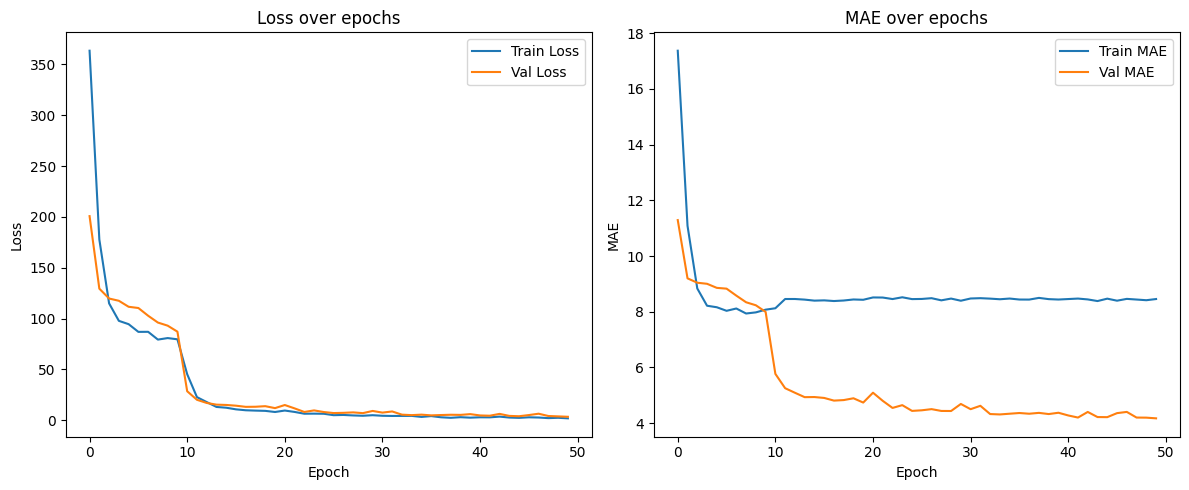

In [23]:
plot_training_history(train_history_all, val_history_all)

## Test the model

Evaluate the model in the test set

In [9]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = torch.argmax(labels, dim=1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            avg_loss = running_loss / total_samples
            avg_acc = correct_preds / total_samples
            test_bar.set_postfix(loss=avg_loss, acc=avg_acc)

    test_loss = running_loss / total_samples
    test_acc = correct_preds / total_samples

    print(f"\nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")


In [8]:
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Loaded model from {model_path}")

In [11]:

def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_mae = 0.0
    total_samples = 0

    all_labels = []
    all_preds = []

    test_bar = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for images, labels in test_bar:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # [batch_size,1]

            outputs = model(images)
            loss = criterion(outputs, labels)
            mae = F.l1_loss(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_mae += mae.item() * images.size(0)
            total_samples += labels.size(0)

            all_labels.append(labels.cpu())
            all_preds.append(outputs.cpu())

            avg_loss = running_loss / total_samples
            avg_mae = running_mae / total_samples
            test_bar.set_postfix(loss=avg_loss, MAE=avg_mae)

    test_loss = running_loss / total_samples
    test_mae = running_mae / total_samples

    all_labels = torch.cat(all_labels).squeeze()
    all_preds = torch.cat(all_preds).squeeze()

    # RMSE
    mse = F.mse_loss(all_preds, all_labels)
    rmse = torch.sqrt(mse).item()

    # R² — usando fórmula: 1 - (SS_res / SS_tot)
    ss_res = torch.sum((all_labels - all_preds) ** 2)
    ss_tot = torch.sum((all_labels - torch.mean(all_labels)) ** 2)
    r2 = 1 - ss_res / ss_tot
    r2 = r2.item()

    print(f"\nTest Loss (MSE): {test_loss:.4f} | Test MAE: {test_mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    return test_loss, test_mae, rmse, r2


best_model_path = 'best_model.pth' 

load_model(model, best_model_path, device)

test_loss, test_mae, test_rmse, test_r2 = test_model(model, test_dataloader, loss_fn, device)

Loaded model from best_model.pth


Testing:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\diogo\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\diogo\AppData\Local\Temp\ipykernel_19508\2525265509.py:21: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mae = F.l1_loss(outputs, labels)
Testing:  90%|█████████ | 9/10 [00:33<00:03,  3.51s/it, MAE=4.82, loss=62.1]c:\Users\diogo\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([18, 1, 1])) that is different to the input size (torch.Size([18, 1])). This will 


Test Loss (MSE): 58.5772 | Test MAE: 4.5966 | RMSE: 1.5814 | R²: 0.9636


True count: 14.00, Predicted: 20.23, Error: 6.23


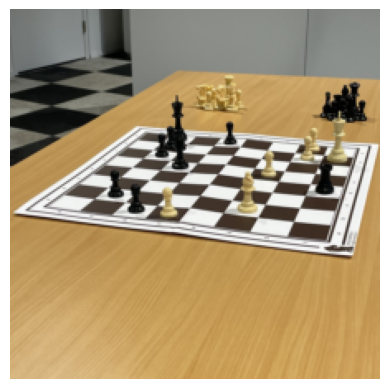

True count: 32.00, Predicted: 26.73, Error: 5.27


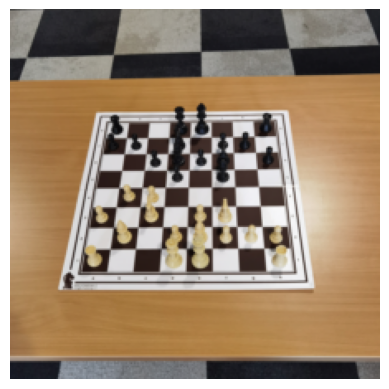

True count: 12.00, Predicted: 16.59, Error: 4.59


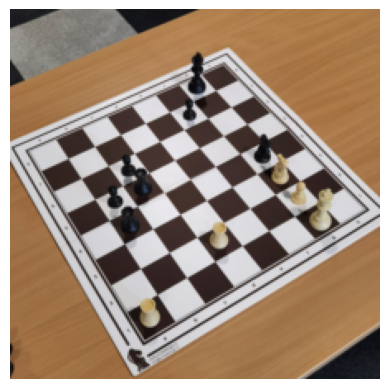

True count: 6.00, Predicted: 10.59, Error: 4.59


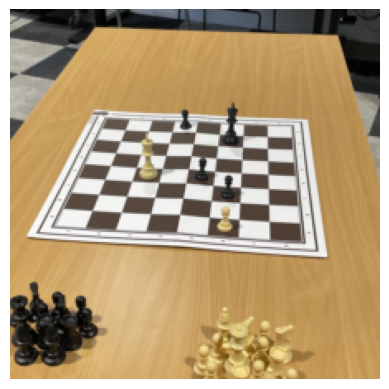

True count: 26.00, Predicted: 21.89, Error: 4.11


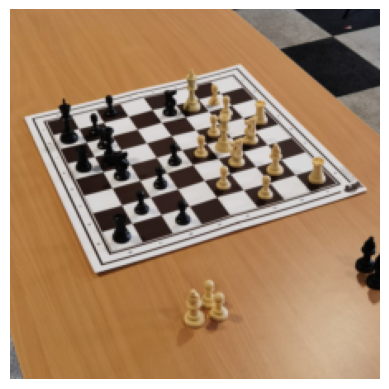

In [12]:
# Função para mostrar imagens
def show_image(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # de [C, H, W] para [H, W, C]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Reverter normalização
    img = np.clip(img, 0, 1)  # Garantir que os valores estão entre 0 e 1
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Função para realizar análise qualitativa
def qualitative_analysis(model, test_dataloader, device):
    model.eval()
    images_list = []
    labels_list = []
    preds_list = []

    with torch.no_grad():
        # Itera sobre o dataloader de teste
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)  # [batch_size, 1]

            outputs = model(images)  # Faz previsões

            images_list.append(images.cpu())  # Armazena imagens para visualização
            labels_list.append(labels.cpu())  # Armazena rótulos reais
            preds_list.append(outputs.cpu())  # Armazena as predições

    # Concatenar os tensores para facilitar o cálculo de erros
    all_images = torch.cat(images_list)
    all_labels = torch.cat(labels_list).squeeze()
    all_preds = torch.cat(preds_list).squeeze()

    # Calcular erros absolutos
    errors = torch.abs(all_preds - all_labels)

    # Ordenar os exemplos pelo erro (maior erro primeiro)
    sorted_indices = torch.argsort(errors, descending=True)

    # Mostrar os exemplos com maior erro
    num_examples = 5  # Quantos exemplos mostrar

    for idx in sorted_indices[:num_examples]:
        print(f"True count: {all_labels[idx].item():.2f}, Predicted: {all_preds[idx].item():.2f}, Error: {errors[idx].item():.2f}")
        show_image(all_images[idx])  # Exibe a imagem

# Exemplo de uso:
# Supondo que tens o modelo e dataloader de teste prontos:
qualitative_analysis(model, test_dataloader, device)
